In [ ]:
# Plot tide model heights at station gz_05 compared to measured tides by gz_05
# Zachary Katz
# 12 April 2024

# Paper Version
# 08 March 2025

# Adapted from Plot Tide Forecasts.ipynb
# https://github.com/tsutterley/pyTMD/blob/main/notebooks/Plot%20Tide%20Forecasts.ipynb

# Imports
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pyproj import CRS, Transformer
import pyTMD.io
import pyTMD.time
import datetime

import shapefile
import shapely
from shapely.plotting import plot_polygon, plot_line
from shapely.geometry import LineString
import timescale

In [2]:
# Helper functions


def inBox(points, bbox):
    # Return points from points that are in bbox
    inbox = []
    for point in points:
        x = point[0]
        y = point[1]
        if x > bbox[0] and x < bbox[2] and y > bbox[1] and y < bbox[3]:
            inbox.append(point)
    return inbox


def interpolateLine(line, dist):
    # Return a new list of points from a linestring that has been interpolated at
    # distance dist. Line must be linestring, dist in m for our case

    # Follows example from:
    # https://stackoverflow.com/questions/34906124/interpolating-every-x-distance-along-multiline-in-shapely
    length = shapely.length(line)
    num_vert = int(np.round(length / dist))
    # print(num_vert)
    return [line.interpolate(n * dist) for n in range(num_vert)]


def xy2ll(x, y):
    """
     Transform coordinates to geodetic coordinates (lon, lat)
     from Antarctic Polar Stereograph coordinates (x, y)

    lon,lat = xy2ll(x,y)
    """
    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    xy_to_ll = Transformer.from_crs(crs_xy, crs_ll, always_xy=True)
    lon, lat = xy_to_ll.transform(x, y)
    return lon, lat


def ll2xy(lon, lat):
    """
    Transform coordinates from input geodetic coordinates (lon, lat)
    to output Antarctic Polar Stereographic coordinates (x, y)
    Can also take lists of floats!

    Parameters
    lon - Geodetic longitude in EPSG:4326 [float]
    lat - Geodetic latitude in EPSG:4326 [float]

    Returns
    x - Antarctic Polar Stereographic (EPSG:3031) x [float]
    y - Antarctic Polar Stereographic (EPSG:3031) y [float]
    """

    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    ll_to_xy = Transformer.from_crs(crs_ll, crs_xy, always_xy=True)
    x, y = ll_to_xy.transform(lon, lat)
    return x, y


def dist_sq(x, y):
    # Returns min dist squared between two points
    delta_x = y[0] - x[0]
    delta_y = y[1] - x[1]
    return delta_x * delta_x + delta_y * delta_y

[(-164.10666784606258, -82.89035091722873), (-164.11944863899666, -82.88604840093853), (-164.13065979487226, -82.88167967126866), (-164.1404120644853, -82.87725803661752), (-164.14824679985216, -82.87277849621526), (-164.15367026411988, -82.8682466394109), (-164.15613669101919, -82.86367329247699), (-164.15563926366553, -82.85908899911364), (-164.1514824140854, -82.85453657824117), (-164.1445964338907, -82.85003717719808), (-164.13525721278046, -82.84560598519623), (-164.1221803131237, -82.8413206420009), (-164.10669364960802, -82.83716594443561), (-164.08927167607496, -82.833129149075), (-164.0695665730821, -82.82926432131445), (-164.04798877206127, -82.82555660891623), (-164.02386686059327, -82.82210239384554), (-163.99757956653588, -82.81891407320283), (-163.96995709416962, -82.81590056675182), (-163.93985325730335, -82.81328813622602), (-163.90812451788628, -82.81100949121755), (-163.87520193745308, -82.80900507369905), (-163.84121868022328, -82.80730200744324), (-163.8061312497591

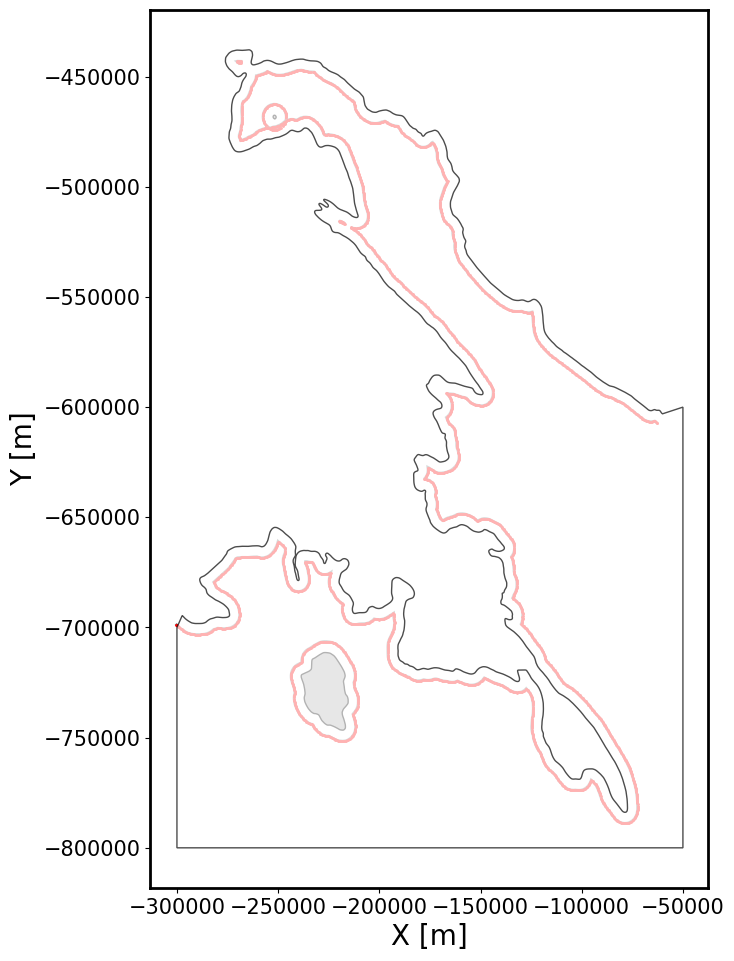

In [3]:
# Extract coordinates of grounding line

# Results in arrays x_tide and y_tide, the x and y positions to calculated
# grounding zone tides at. (Red dots in figure). Converted to lons and lats and
# grouped as points in array lon_lats.
# Creates polygons shelf, rumples, and island for use to determine if points are
# on floating or grounded ice.

# Importing grounding line and conversion to shapely adapted from
# https://gis.stackexchange.com/questions/113799/reading-shapefile-in-python

# Tuning parameters
offset = 5000  # Distance from grounding line to offset, m
pt_dist = 500  # Distance between tide sampling points, m

# Arrays to pass to tides
x_tide = []
y_tide = []

bbox = [-300000, -800000, -60000, -420000]  # Includes all of Crary
fig, ax = plt.subplots(
    figsize=[(bbox[2] - bbox[0]) / 100000 * 3, (bbox[3] - bbox[1]) / 100000 * 3]
)
gl_path = "/mnt/c/Users/ZacharyKatz/Desktop/Research/Background/Antarctica_masksX/scripps_antarctica_polygons_v1.shp"
sf = shapefile.Reader(gl_path)
for i, shape in enumerate(sf.shapes(bbox=bbox)):
    if i > 0:
        points = shape.points
        # Only get points within bounding box
        inbox = inBox(points, bbox)
        line = LineString(inbox)
        offset_line = line.offset_curve(offset)
        plot_line(offset_line, ax=ax, add_points=False, color="gray")

        interpolated = interpolateLine(offset_line, pt_dist)
        xs = [point.x for point in interpolated]
        ys = [point.y for point in interpolated]
        ax.scatter(xs, ys, s=1, color="red")
        x_tide.append(xs)
        y_tide.append(ys)

        if len(inbox) > 1000:  # Check if main array, not an island
            x, y = line.xy
            border = LineString(
                [
                    [x[0], y[0]],
                    [-50000, -600000],
                    [-50000, -800000],
                    [-300000, -800000],
                    [-300000, -700000],
                    [x[-1], y[-1]],
                ]
            )
            polygon = shapely.polygonize([line, border])
            shelf = polygon.geoms[0]
            plot_polygon(
                shelf,
                ax=ax,
                add_points=False,
                edgecolor="black",
                facecolor="white",
                alpha=0.7,
            )
        else:
            polygon = shapely.polygonize([line])
            if len(inbox) < 100:
                rumples = polygon.geoms[0]
                plot_polygon(rumples, ax=ax, add_points=False, color="black")
            else:
                island = polygon.geoms[0]
                plot_polygon(island, ax=ax, add_points=False, color="black")

ax.xaxis.set_major_locator(ticker.MultipleLocator(50000))
ax.yaxis.set_major_locator(ticker.MultipleLocator(50000))
ax.set_xlabel("X [m]", size=20)
ax.set_ylabel("Y [m]", size=20)
ax.tick_params(labelsize=15)

# Flatten the list. Not sure why this works but here's the source
# https://www.scaler.com/topics/flatten-list-python/
x_tide = sum(x_tide, [])
y_tide = sum(y_tide, [])

lon_lats = [xy2ll(x0, y0) for x0, y0 in zip(x_tide, y_tide)]
lons = [x[0] for x in lon_lats]
lats = [x[1] for x in lon_lats]
print(lon_lats)

MODEL

In [4]:
# Setup parameters
(year1, month1, day1) = (2019, 3, 30)  # First day of gz_05 data
# Calcluate date since Jan 1, 1992 [The format pyTMD wants it in]
# minutes = np.arange(7 * 3 * 1440) # Calcuate tides every minute for 2 weeks
hours = np.arange(366 * 24 * 2)  # Calcuate tides every minute for 2 weeks
plot_t = np.arange(
    datetime.datetime(2019, 3, 30),
    datetime.datetime(2020, 3, 30),
    datetime.timedelta(hours=0.5),
).astype(datetime.datetime)
tide_time = timescale.time.convert_calendar_dates(year1, month1, day1, hour=hours / 2)

print(len(tide_time))
print(len(plot_t))

17568
17568


In [5]:
# Setup model
dir = "/mnt/c/Users/ZacharyKatz/Desktop/Research/Background"
mod = "CATS2008-v2023"
model = pyTMD.io.model(dir, format="netcdf").elevation(mod)
print(model.format)
constituents = pyTMD.io.OTIS.read_constants(
    model.grid_file,
    model.model_file,
    model.projection,
    type=model.type,
    grid=model.format,
)
c = constituents.fields

# CALCULATE TIDES ALONG BASIN #
DELTAT = np.zeros_like(tide_time)
amp, ph, D = pyTMD.io.OTIS.interpolate_constants(
    np.atleast_1d(lons),
    np.atleast_1d(lats),
    constituents,
    model.projection,
    type=model.type,
    method="spline",
    extrapolate=True,
)
# calculate complex phase in radians for Euler's
cph = -1j * ph * np.pi / 180.0
# calculate constituent oscillation
hc = amp * np.exp(cph)

TMD3


In [6]:
tides = []
for i in range(len(tide_time)):
    TIDE = pyTMD.predict.map(
        tide_time[i], hc, c, deltat=DELTAT[i], corrections=model.format
    )
    MINOR = pyTMD.predict.infer_minor(
        tide_time[i], hc, c, deltat=DELTAT[i], corrections=model.format
    )
    TIDE.data[:] += MINOR.data[:]
    # convert to centimeters
    TIDE.data[:] *= 100.0
    tides.append(TIDE.data)

<xarray.DataArray 'VX' (y: 12445, x: 12445)> Size: 620MB
[154878025 values with dtype=float32]
Coordinates:
  * x        (x) float64 100kB -2.8e+06 -2.8e+06 ... 2.799e+06 2.8e+06
  * y        (y) float64 100kB 2.8e+06 2.8e+06 2.799e+06 ... -2.799e+06 -2.8e+06
Attributes:
    long_name:     VX
    actual_range:  [2.34232033e-07 4.21826514e+03]


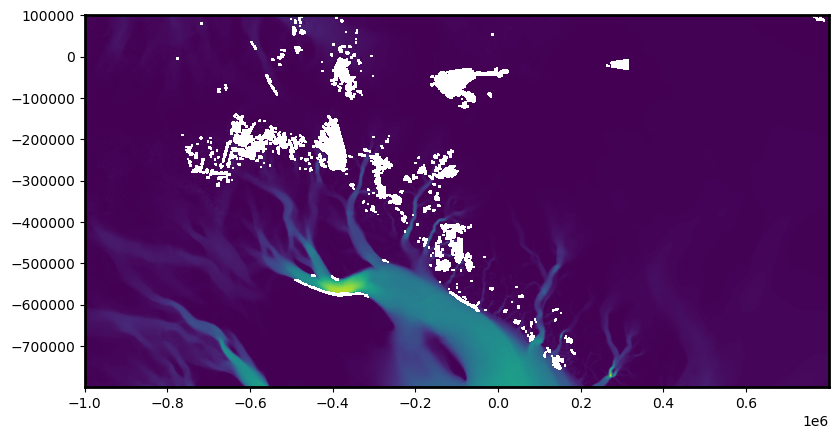

In [7]:
# Import and plot ice velocity
import xarray as xr

vel_mag_path = "/mnt/c/Users/ZacharyKatz/Desktop/Research/Background/antarctic_ice_vel_phase_map_v01-vmag.nc"
moa_path = (
    "/mnt/c/Users/ZacharyKatz/Desktop/Research/Background/moa750_2009_hp1_v1.1.tif"
)
vel_mag = xr.open_dataarray(vel_mag_path)
print(vel_mag)
bbox = [-300000, -800000, -60000, -420000]  # Includes all of Crary
vel_mag = vel_mag.isel(x=slice(4000, 8000), y=slice(6000, 8000))
x_min_v, x_max_v = vel_mag["x"].min().item(), vel_mag["x"].max().item()
y_min_v, y_max_v = vel_mag["y"].min().item(), vel_mag["y"].max().item()

fig, ax = plt.subplots(
    figsize=[(bbox[2] - bbox[0]) / 100000 * 4, (bbox[3] - bbox[1]) / 100000 * 3]
)
ax.imshow(vel_mag, extent=(x_min_v, x_max_v, y_min_v, y_max_v), cmap="viridis")

(-800000.0, -420000.0)

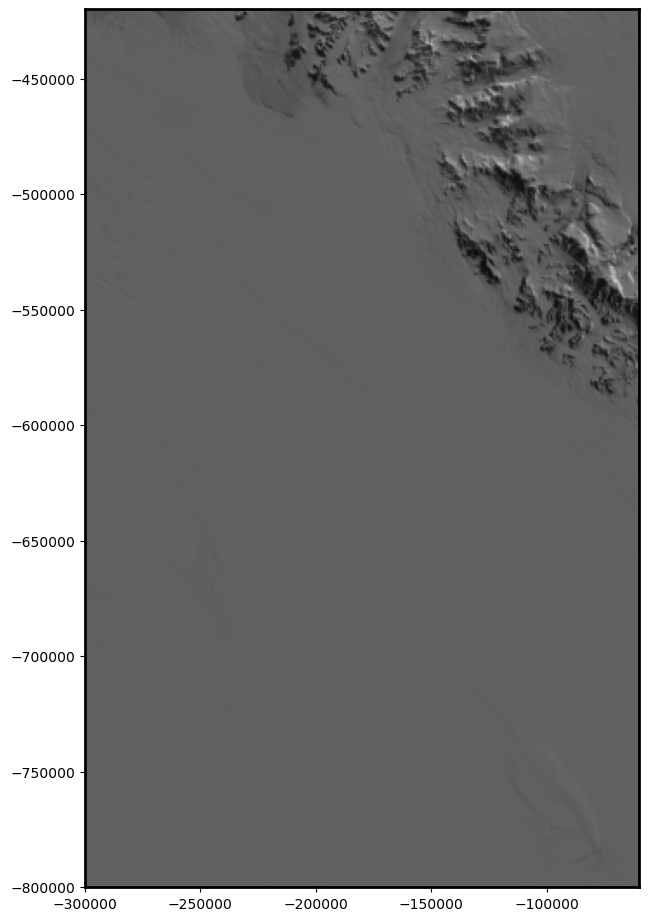

In [8]:
import rasterio

with rasterio.open(moa_path) as moa:
    bounds = moa.bounds
    left, bottom, right, top = bounds.left, bounds.bottom, bounds.right, bounds.top
    moa_dat = moa.read(1)

ext = (left, right, bottom, top)
fig, ax = plt.subplots(
    figsize=[(bbox[2] - bbox[0]) / 100000 * 4, (bbox[3] - bbox[1]) / 100000 * 3]
)
ax.imshow(moa_dat, extent=ext, cmap="gray")
ax.set_xlim([bbox[0], bbox[2]])
ax.set_ylim([bbox[1], bbox[3]])

In [9]:
from cmap import Colormap

oslo = Colormap("crameri:oslo").to_mpl()

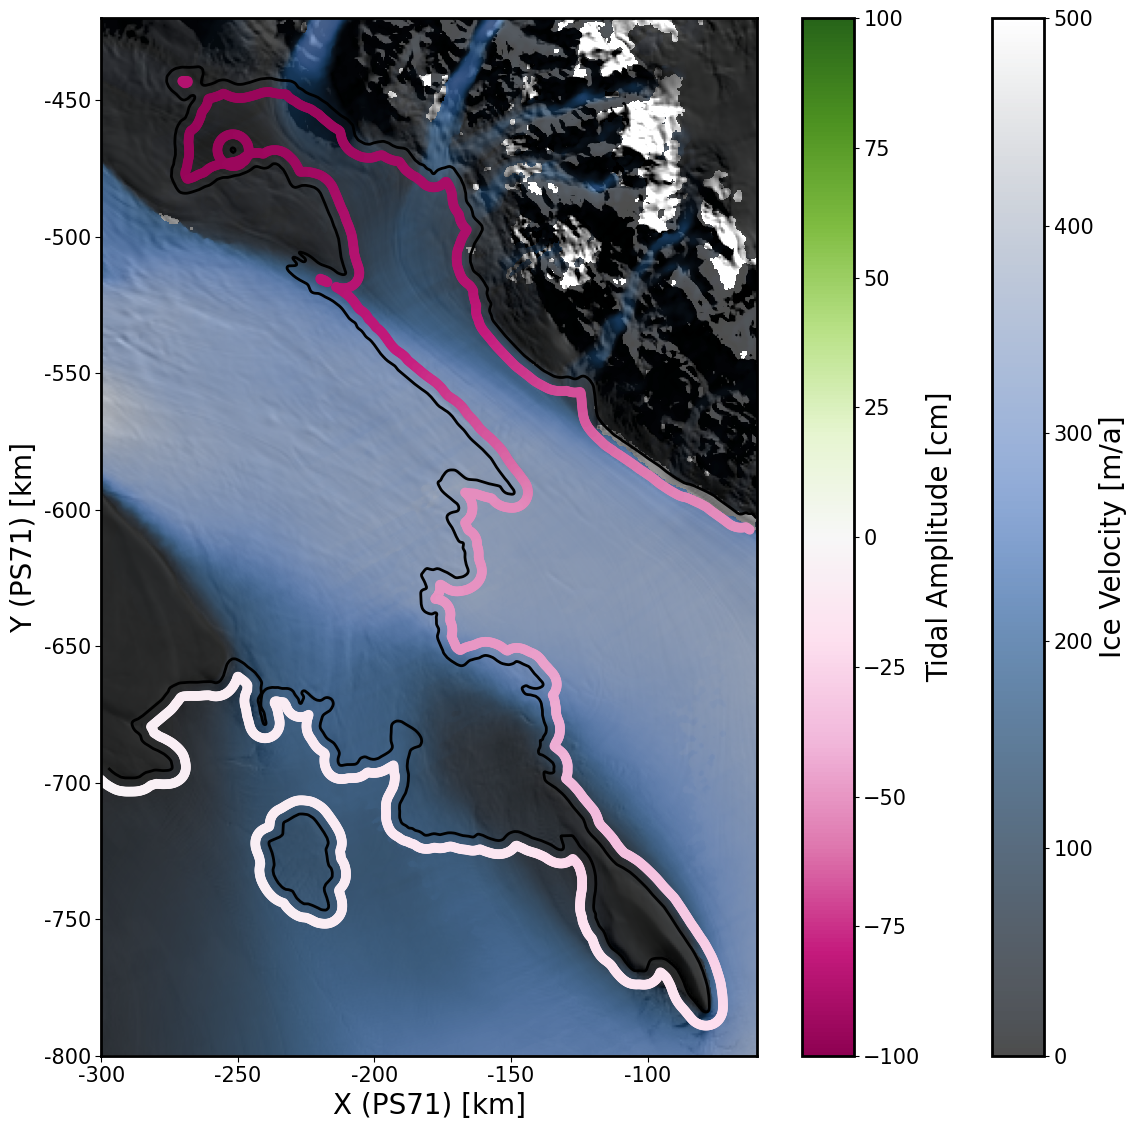

In [ ]:
# Static frame
bbox = [-300000, -800000, -60000, -420000]  # Includes all of Crary
gl_path = "/mnt/c/Users/ZacharyKatz/Desktop/Research/Background/Antarctica_masksX/scripps_antarctica_polygons_v1.shp"
sf = shapefile.Reader(gl_path)
fig, ax = plt.subplots(
    figsize=[(bbox[2] - bbox[0]) / 100000 * 5, (bbox[3] - bbox[1]) / 100000 * 3]
)
fig.set_tight_layout(True)
ax.imshow(moa_dat, extent=ext, cmap="gray", vmin=15000, vmax=17000)
v = ax.imshow(
    vel_mag,
    extent=(x_min_v, x_max_v, y_min_v, y_max_v),
    cmap=oslo,
    vmax=500,
    vmin=0,
    alpha=0.7,
)
tide = ax.scatter(x_tide, y_tide, c=tides[0], vmax=100, vmin=-100, cmap="PiYG")
for i, shape in enumerate(sf.shapes(bbox=bbox)):
    if i > 0:
        points = shape.points
        # Only get points within bounding box
        inbox = inBox(points, bbox)
        line = LineString(inbox)
        plot_line(line, ax=ax, add_points=False, color="black")
x_min, x_max = bbox[0], bbox[2]
y_min, y_max = bbox[1], bbox[3]
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
KM_SCALE = 1e3
ticks_x = ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x / KM_SCALE))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x / KM_SCALE))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_xlabel("X (PS71) [km]", size=20)
ax.set_ylabel("Y (PS71) [km]", size=20)
ax.tick_params(labelsize=15)
ax.tick_params(size=4)
# ax.set_facecolor("black")
cbarv = fig.colorbar(v)
cbarv.ax.tick_params(labelsize=15)
cbarv.ax.set_ylabel("Ice Velocity [m/a]", size=20)

cbaramp = fig.colorbar(tide)
cbaramp.ax.tick_params(labelsize=15)
cbaramp.ax.set_ylabel("Tidal Amplitude [cm]", size=20)

fig.tight_layout()
fig.savefig("MovieS2Still.png", dpi=300)

In [ ]:
def update(frame):
    ax.clear()
    fig.set_tight_layout(True)
    ax.imshow(moa_dat, extent=ext, cmap="gray", vmin=15000, vmax=17000)
    ax.imshow(
        vel_mag,
        extent=(x_min_v, x_max_v, y_min_v, y_max_v),
        cmap=oslo,
        vmax=500,
        vmin=0,
        alpha=0.7,
    )
    tide = ax.scatter(x_tide, y_tide, c=tides[frame], vmax=100, vmin=-100, cmap="PiYG")
    for i, shape in enumerate(sf.shapes(bbox=bbox)):
        if i > 0:
            points = shape.points
            # Only get points within bounding box
            inbox = inBox(points, bbox)
            line = LineString(inbox)
            plot_line(line, ax=ax, add_points=False, color="black")
    x_min, x_max = bbox[0], bbox[2]
    y_min, y_max = bbox[1], bbox[3]
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    KM_SCALE = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x / KM_SCALE))
    ax.xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x / KM_SCALE))
    ax.yaxis.set_major_formatter(ticks_y)
    ax.set_xlabel("X (PS71) [km]", size=20)
    ax.set_ylabel("Y (PS71) [km]", size=20)
    ax.tick_params(labelsize=15)
    ax.tick_params(size=4)

    if frame % 2 == 0:
        plot_text = str(plot_t[frame])[:16]
    else:
        plot_text = str(plot_t[frame - 1])[:16]
    ax.text(0.02, 0.02, f"{plot_text}", transform=ax.transAxes, c="white", size=15)

    return tide

In [ ]:
# Make and save animation [save function several hrs]
ani = FuncAnimation(fig=fig, func=update, frames=len(tides), interval=100)
# ani.save(filename="./30MinTides.gif", writer="pillow")
ani.save(filename="./MovieS2.mp4", writer="ffmpeg")